# LLHP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate

In [2]:
parse_dims = ['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'energy', 'track_fraction']
def parse(stats):
    out = {}
    out['mean'] = {}
    out['std'] = {}
    out['mle'] = {}
    out['map'] = {}    
    stats = [s.strip() for s in stats]
    print '\n'.join(stats)
    res = stats[4:12]
    for r in res:
        dim, p, e = [float(x) for x in r.split()]
        out['mean'][parse_dims[int(dim)-1]] = p
        out['std'][parse_dims[int(dim)-1]] = e
    out['mean']['track_energy'] = out['mean']['energy'] * out['mean']['track_fraction']
    out['mean']['cascade_energy'] = out['mean']['energy'] * (1 - out['mean']['track_fraction'])
    out['std']['track_energy'] = out['std']['energy'] * out['mean']['track_fraction']
    out['std']['cascade_energy'] = out['std']['energy'] * (1 - out['mean']['track_fraction'])
    
    res = stats[15:23]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['mle'][parse_dims[int(dim)-1]] = p
    out['mle']['track_energy'] = out['mle']['energy'] * out['mle']['track_fraction']
    out['mle']['cascade_energy'] = out['mle']['energy'] * (1 - out['mle']['track_fraction'])
    
    res = stats[26:34]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['map'][parse_dims[int(dim)-1]] = p
    out['map']['track_energy'] = out['map']['energy'] * out['map']['track_fraction']
    out['map']['cascade_energy'] = out['map']['energy'] * (1 - out['map']['track_fraction'])
    
    return out

In [44]:
# this looks nice
#event = 190
#quite nice one
#event = 33
# this one's fucked
#event = 142
#this one's spot on 80 GeV
#event = 133
# a normal one
event = 7

#failed
#event = 42
#event = 41
#event = 55

#bad
#event = 80
event = 7

#llhp_data = np.load('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-llhp.npy'%event)
#llhp_data = np.load('/data/justin/retro/recos/2018-03-28/tblptckvlog/0/evt%i-llhp.npy'%event)
llhp_data = np.load('/data/justin/retro/recos/2018-04-06.0//14600/5.47/evt%i-llhp.npy'%event)

#new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

#llhp_data.dtype.names = new_names

llhp = pn.PointData(llhp_data)

#with open('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-stats.dat'%event, 'r') as f:
#with open('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-stats.dat'%event, 'r') as f:
#    mn_stats = f.readlines()
#mn_stats = parse(mn_stats)

truth = np.load('/data/icecube/sim/ic86/retro/14600/5.47/truth.npy')
truth = truth[event]
#truth = truth[event]
#truth['track_azimuth'] = truth['azimuth']
#truth['track_zenith'] = np.arccos(truth['coszen'])
#truth['track_energy'] = truth['highest_energy_daughter_energy']
#truth['t'] = truth['time']

In [54]:
bins = pn.Grid()

bins['x'].edges = np.linspace(truth['x'] - 50 , truth['x'] + 50, 101)
bins['y'].edges = np.linspace(truth['y'] - 50 , truth['y'] + 50, 101)
bins['z'].edges = np.linspace(truth['z'] - 50 , truth['z'] + 50, 101)
bins['time'].edges = np.linspace(truth['time'] - 150 , truth['time'] + 150, 101)
bins['track_azimuth'].edges = np.linspace(0, 2*np.pi, 101)
bins['track_zenith'].edges = np.linspace(0, np.pi, 101)
bins['track_energy'].edges = np.linspace(0 , 50, 101)
bins['cascade_energy'].edges = np.linspace(0 , 50, 101)

In [55]:
data = {}
data['xy'] = pn.GridData(bins['x','y'])
data['xt'] = pn.GridData(bins['x','time'])
data['xz'] = pn.GridData(bins['x','z'])
data['tz'] = pn.GridData(bins['time','z'])
data['azzen'] = pn.GridData(bins['track_azimuth','track_zenith'])
data['ezen'] = pn.GridData(bins['track_energy','track_zenith'])
data['ten'] = pn.GridData(bins['time','track_energy'])
data['tzen'] = pn.GridData(bins['time','track_zenith'])
data['energy'] = pn.GridData(bins['cascade_energy','track_energy'])

In [43]:
crazy_data = data

In [56]:
for key in data.keys():
    data[key]['llh'] = llhp.histogram('llh', function=np.nanmax)
    data[key]['count'] = llhp.histogram('llh', method='count')

In [100]:
def plot_estimator(ax, estimator, var_x, var_y, est_var='weighted_mean', color='w'):
        ax.errorbar(estimator[est_var][var_x],
                    estimator[est_var][var_y],
                    marker='o',
                    c=color,
                    ms=5)
        ax.errorbar(estimator['low'][var_x],
                    estimator[est_var][var_y],
                    marker='>',
                    c=color,
                    ms=5)
        ax.errorbar(estimator['high'][var_x],
                    estimator[est_var][var_y],
                    marker='<',
                    c=color,
                    ms=5)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['low'][var_y],
                    marker='^',
                    c=color,
                    ms=5)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['high'][var_y],
                    marker='v',
                    c=color,
                    ms=5)

In [95]:
estimator = estimate(llhp.data, percentile_nd=0.95)
#print estimator

In [47]:
len(llhp.data)

23079

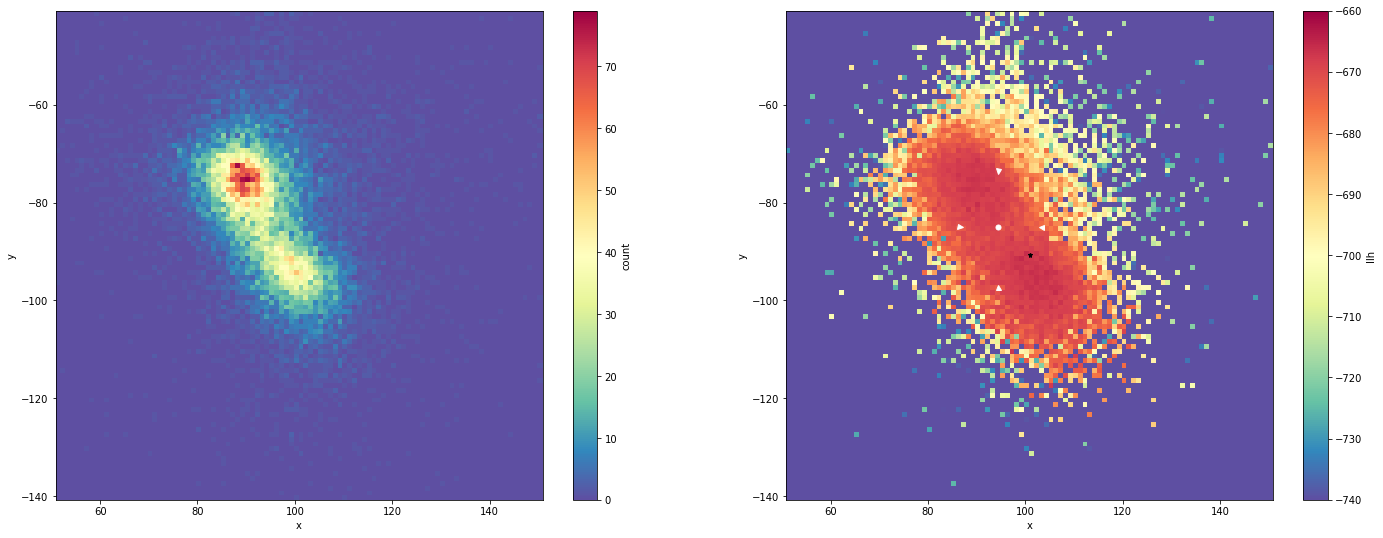

In [103]:
fig, axes = plt.subplots(figsize=(24, 9), ncols=2, nrows=1)
key = 'xy'
data[key].plot_map(fig, axes[0], 'count', cmap='Spectral_r', cbar=True)
data[key].plot_map(fig, axes[1], 'llh', cmap='Spectral_r', cbar=True, vmin=-740, vmax=-660)
fig.savefig('llhp.png')
plot_estimator(axes[1], estimator, 'x', 'y')
axes[1].plot(truth['x'], truth['y'], ms=5, marker='*', color='k')
#layer = 'tz'
#plot_map(data[layer], axes[0], var='count', vmin =0, truth=truth, stats=mn_stats, best=False, estimator=estimator, est_var='median')
#plot_map(data[layer], axes[1], var='llh', vmin=-720, truth=truth, stats=mn_stats, best=True, estimator=estimator, est_var='median')

In [16]:
truth

OrderedDict([('pdg', -14),
             ('x', 166.00375876601564),
             ('y', 47.75865582444311),
             ('z', -324.7268327006121),
             ('time', 9554.061774446025),
             ('energy', 31.22145863058618),
             ('coszen', 0.79369186678801007),
             ('azimuth', 0.8929531151525705),
             ('unique_id', 140000010103111),
             ('highest_energy_daughter_pdg', -13),
             ('highest_energy_daughter_energy', 29.00230931556597),
             ('highest_energy_daughter_length', 104.05682878288889),
             ('highest_energy_daughter_coszen', 0.78648816548868949),
             ('highest_energy_daughter_azimuth', 0.9131616331541856),
             ('longest_daughter_pdg', -13),
             ('longest_daughter_energy', 29.00230931556597),
             ('longest_daughter_length', 104.05682878288889),
             ('longest_daughter_coszen', 0.78648816548868949),
             ('longest_daughter_azimuth', 0.9131616331541856),
          

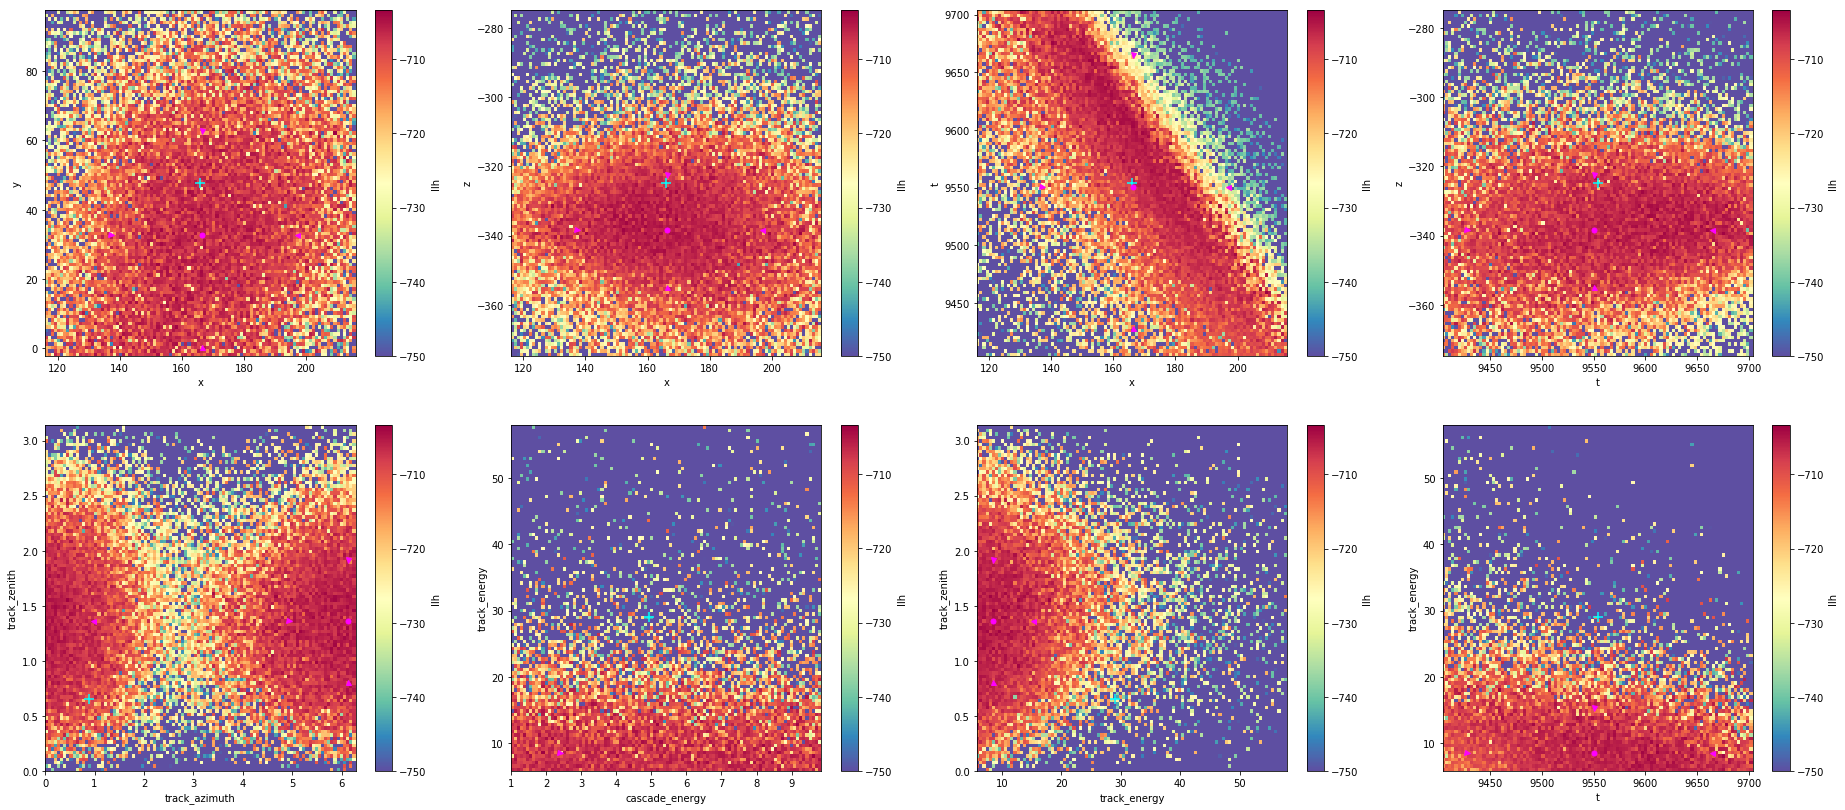

In [19]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
kwargs = {'vmin':-750, 'truth':truth, 'estimator':estimator, 'best':False} #, 'stats': mn_stats}
plot_map(data['xy'], axes[0,0], **kwargs)
plot_map(data['xz'], axes[0,1], **kwargs)
plot_map(data['xt'], axes[0,2], **kwargs)
plot_map(data['tz'], axes[0,3], **kwargs)
plot_map(data['azzen'], axes[1,0], **kwargs)
plot_map(data['energy'], axes[1,1], **kwargs)
plot_map(data['ezen'], axes[1,2], **kwargs)
plot_map(data['ten'], axes[1,3], **kwargs)

In [126]:
mn_stats

{'map': {'cascade_energy': 0.03875257748870347,
  'energy': 0.5908078104471909,
  't': 3346.522689691279,
  'track_azimuth': 2.4161452007743627,
  'track_energy': 0.5520552329584875,
  'track_fraction': 0.9344074726104736,
  'track_zenith': 0.8688395336079782,
  'x': 521.8113827705383,
  'y': -31.997295022010803,
  'z': -363.3730125427246},
 'mean': {'cascade_energy': 31.143160300012806,
  'energy': 63.99131576401881,
  't': 8247.009149965874,
  'track_azimuth': 3.168544646713854,
  'track_energy': 32.848155464006,
  'track_fraction': 0.5133220824078748,
  'track_zenith': 1.540633056447536,
  'x': 17.808455595584128,
  'y': 21.159974156026585,
  'z': 11.465220008891292},
 'mle': {'cascade_energy': 0.9629221212659805,
  'energy': 13.403751039938362,
  't': 5367.741356706363,
  'track_azimuth': 2.3652635523894734,
  'track_energy': 12.44082891867238,
  'track_fraction': 0.9281602501869202,
  'track_zenith': 1.2288741061317192,
  'x': 501.70447766780853,
  'y': -300.77493965625763,
  'z':